In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import sys; sys.path.append("../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
data_dir = root_dir / "Data"

model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

log_dir = root_dir / "Logs"
log_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
# This dataset is used for object detection and segmentation, but here we will adapt it
# for image classification only.
config = maskflow.config.load_config(root_dir / "config.yaml")

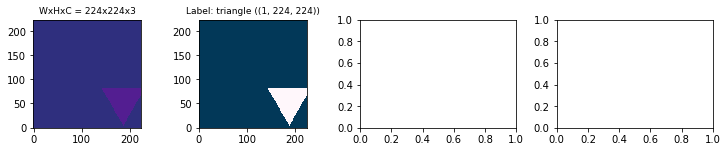

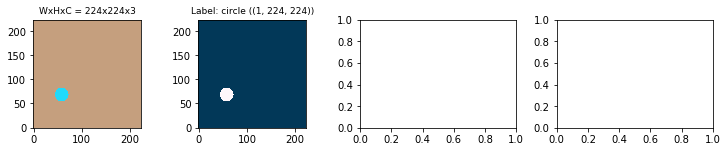

In [18]:
# Load training and test dataset
class_names = config["DATASET"]["CLASS_NAMES"]

train_file_path = data_dir / "train.tfrecords"
test_file_path = data_dir / "test.tfrecords"

train_raw_dataset = maskflow.dataset.parse(train_file_path, config, repeat_count=1,
                                           shuffle=True, do_preprocess=True)

test_raw_dataset = maskflow.dataset.parse(test_file_path, config, repeat_count=1,
                                          shuffle=False, do_preprocess=True)

# Display
dataset_to_display = train_raw_dataset.take(2)
maskflow.viz.batch_display_top_masks(dataset_to_display, class_names, basesize=10, limit=3, cmap="PuBu_r")

In [19]:
# Preprocess the dataset
train_dataset = train_raw_dataset
test_dataset = test_raw_dataset

# Normalize the images.
def _normalize_image_intensities(pixel_mean, pixel_std):
    def _fn(datum):
        image = tf.cast(datum['image'], dtype="float32")
        image -= pixel_mean
        image /= pixel_std
        datum['image'] = image
        return datum
    return _fn

pixel_mean = config["DATASET"]['PIXEL_MEAN']
pixel_std = config["DATASET"]['PIXEL_STD']

normalize_fn = _normalize_image_intensities(pixel_mean, pixel_std)
train_dataset = train_dataset.map(normalize_fn)
test_dataset = test_dataset.map(normalize_fn)

def _prepare_classification(datum):
    """Prepare a Maskflow dataset for classification."""
    image = datum['image']
    label = datum['label_ids'][0]
    return image, label

train_dataset = train_dataset.map(_prepare_classification)
test_dataset = test_dataset.map(_prepare_classification)

image, label = [datum for datum in train_dataset.take(1)][0]

In [20]:
# Build the model
num_classes = len(class_names)

image_size = config["DATASET"]['IMAGE_SIZE']
n_channels = config["DATASET"]['N_CHANNELS']
input_shape = (None, image_size, image_size, n_channels)

tf.keras.backend.clear_session()
model = maskflow.model.ResNet18(num_classes=num_classes, include_top=True, data_format='channels_last')
model.build(input_shape=input_shape)

model.summary()
model.compute_output_shape(input_shape)

Model: "ResNet_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block_group_1 (ConvNormReLuP multiple                  9728      
_________________________________________________________________
block_group_2 (BlockGroup)   multiple                  152896    
_________________________________________________________________
block_group_3 (BlockGroup)   multiple                  526720    
_________________________________________________________________
block_group_4 (BlockGroup)   multiple                  2102016   
_________________________________________________________________
block_group_5 (BlockGroup)   multiple                  8398336   
_________________________________________________________________
classify_block (ClassifierBl multiple                  1539      
Total params: 11,191,235
Trainable params: 11,184,323
Non-trainable params: 6,912
_________________________________________

TensorShape([None, 3])

In [21]:
# Run training
batch_size = 32
n_epochs = 5

#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
log_path = log_dir / datetime.datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
tb = tf.keras.callbacks.TensorBoard(log_dir=str(log_path), write_images=False, write_graph=True)
#scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
#chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoints_path), monitor="accuracy", save_best_only=True, verbose=1)
callbacks = [tb]#, scheduler, chkpt]

train_dataset_fit = train_dataset.batch(batch_size)
train_dataset_fit = train_dataset_fit.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset_fit = test_dataset.batch(batch_size)
test_dataset_fit = test_dataset_fit.prefetch(tf.data.experimental.AUTOTUNE)

model.fit(train_dataset_fit, validation_data=test_dataset_fit, epochs=n_epochs,
          callbacks=callbacks, verbose=1)

Epoch 1/5


ValueError: Variable <tf.Variable 'block_group_1/block_group_1/conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32> has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

In [21]:
# Export to Saved Model
model_path = model_dir / "Classification" / "resnet"
model_path.mkdir(exist_ok=True, parents=True)
tf.saved_model.save(model, str(model_path))

I0528 16:47:48.690078 140216131524416 builder_impl.py:770] Assets written to: /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/Classification/resnet/assets
2019-05-28 16:47:48,690:INFO:tensorflow: Assets written to: /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/Classification/resnet/assets


In [22]:
# Load model
loaded = tf.saved_model.load(str(model_path))
infer = loaded.signatures["serving_default"]

In [31]:
image, label = [datum for datum in test_dataset.take(1)][0]
image = tf.expand_dims(image, 0)
label = tf.expand_dims(label, 0)

In [32]:
infer(image)

{'output_1': <tf.Tensor: id=78088, shape=(1, 3), dtype=float32, numpy=array([[0., 1., 0.]], dtype=float32)>}

In [ ]:
# Inference
i = 843
im = test_images[i:i + 35]
plt.imshow(im[0, :, :, 0])

im_tensor = tf.constant(im.astype('float32'))
dummy = tf.constant(np.tile(np.arange(0, 10), (len(im_tensor), 1)))
inputs = dict(images=im_tensor, dummy_inputs=dummy)

outputs = infer(**inputs)

np.argmax(outputs['output_1'])
#np.argmax(outputs['labels'][0])